In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [2]:
# folder to save generated images
if not os.path.exists("generated_images"):
    os.makedirs("generated_images")

print("TensorFlow version:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())

TensorFlow version: 2.18.0
Eager execution: True


In [3]:
# Load and preprocess CIFAR-10 dataset
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256
#NOISE_DIM = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
# Generator model with additional convolutional layers
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(4*4*256, use_bias=False, input_shape=(100,)),  # Adjusted for CIFAR-10
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((4, 4, 256)),  # Adjusted for CIFAR-10
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')  # 3 channels for CIFAR-10
    ])
    return model

generator = make_generator_model()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4096)                │         409,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │           4,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,455,552 (5.55 MB)

 Trainable params: 1,446,976 (5.52 MB)

 Non-trainable params: 8,576 (33.50 KB)

In [5]:
# Discriminator model updated for CIFAR-10
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),  # 3 channels for CIFAR-10
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,033,345 (3.94 MB)

 Trainable params: 1,033,345 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [7]:
# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
# Save generated images
def save_images(epoch, generator):
    noise = tf.random.normal([16, 100])  # Generate 16 images
    generated_images = generator(noise, training=False)
    generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]

    plt.figure(figsize=(4, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.savefig(f'generated_images_epoch_{epoch}.png')
    plt.close()

In [9]:
# Training function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [10]:
#Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Save generated images every 10 epochs
        if (epoch + 1) % 10 == 0:
            save_images(epoch + 1, generator)
            print(f'Epoch {epoch + 1} completed. Images saved.')

In [11]:
#def train(dataset, epochs):
    # A fixed seed vector to visualize the generator's progress
 #   seed = tf.random.normal([16, NOISE_DIM])

    # Lists to store average epoch losses for plotting
   # all_gen_losses = []
   # all_disc_losses = []

    #for epoch in range(1, epochs + 1):
     #   gen_loss_list = []
      #  disc_loss_list = []

       # for image_batch in dataset:
        #    gl, dl = train_step(image_batch)
         #   gen_loss_list.append(gl)
          #  disc_loss_list.append(dl)

        #avg_gen_loss = np.mean(gen_loss_list)
        #avg_disc_loss = np.mean(disc_loss_list)
        #all_gen_losses.append(avg_gen_loss)
        #all_disc_losses.append(avg_disc_loss)

        # Print average losses for this epoch
        #print(f'Epoch {epoch}/{epochs} '
         #     f'| Gen Loss: {avg_gen_loss:.4f} '
          #    f'| Disc Loss: {avg_disc_loss:.4f}')

        # Save generated images every 10 epochs
        #if (epoch % 10) == 0:
         #   generate_and_save_images(generator, epoch, seed)

    #return all_gen_losses, all_disc_losses

In [12]:
# Run the training
EPOCHS = 300
train(train_dataset, EPOCHS)

Epoch 10 completed. Images saved.
Epoch 20 completed. Images saved.
Epoch 30 completed. Images saved.
Epoch 40 completed. Images saved.
Epoch 50 completed. Images saved.
Epoch 60 completed. Images saved.
Epoch 70 completed. Images saved.
Epoch 80 completed. Images saved.
Epoch 90 completed. Images saved.
Epoch 100 completed. Images saved.
Epoch 110 completed. Images saved.
Epoch 120 completed. Images saved.
Epoch 130 completed. Images saved.
Epoch 140 completed. Images saved.
Epoch 150 completed. Images saved.
Epoch 160 completed. Images saved.
Epoch 170 completed. Images saved.
Epoch 180 completed. Images saved.
Epoch 190 completed. Images saved.
Epoch 200 completed. Images saved.
Epoch 210 completed. Images saved.
Epoch 220 completed. Images saved.
Epoch 230 completed. Images saved.
Epoch 240 completed. Images saved.
Epoch 250 completed. Images saved.
Epoch 260 completed. Images saved.
Epoch 270 completed. Images saved.
Epoch 280 completed. Images saved.
Epoch 290 completed. Images s

In [13]:
#plt.figure(figsize=(8,5))
#plt.plot(range(1, EPOCHS+1), all_gen_losses, label='Generator Loss')
#plt.plot(range(1, EPOCHS+1), all_disc_losses, label='Discriminator Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.title('Generator and Discriminator Loss Over Time')
#plt.legend()
#plt.show()

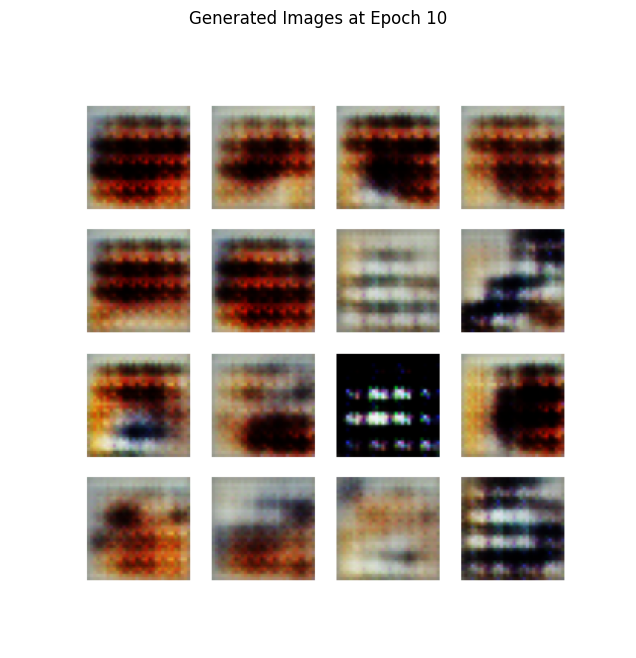

In [14]:

# Path to the saved image at epoch 10
image_path = 'generated_images_epoch_10.png'

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title('Generated Images at Epoch 10')
plt.show()

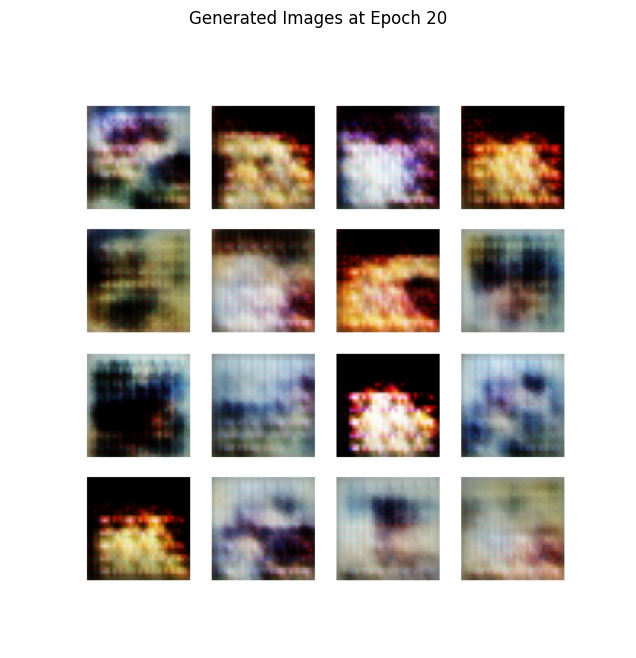

In [15]:

# Path to the saved image at epoch 20
image_path = 'generated_images_epoch_20.png'

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title('Generated Images at Epoch 20')
plt.show()

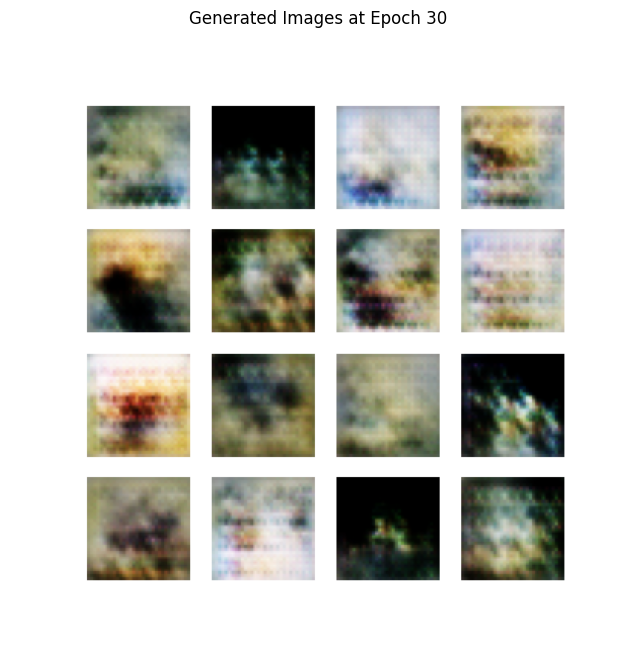

In [16]:

# Path to the saved image at epoch 30
image_path = 'generated_images_epoch_30.png'

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title('Generated Images at Epoch 30')
plt.show()

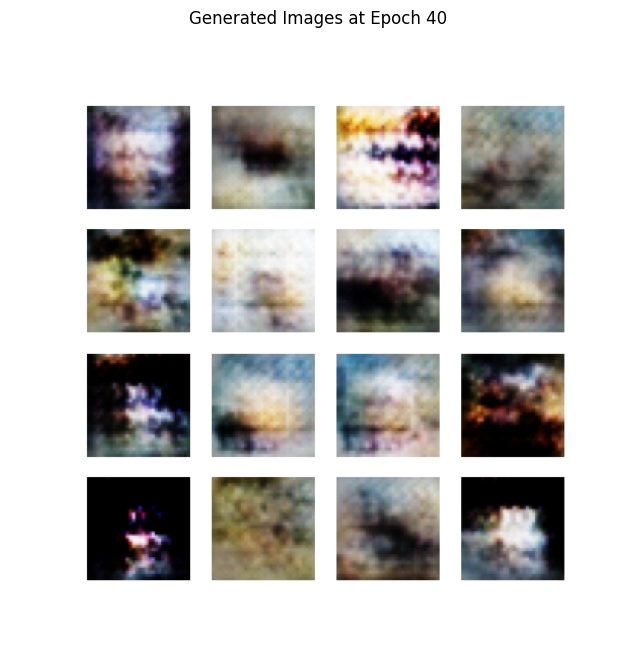

In [17]:
# Path to the saved image at epoch 40
image_path = 'generated_images_epoch_40.png'

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title('Generated Images at Epoch 40')
plt.show()

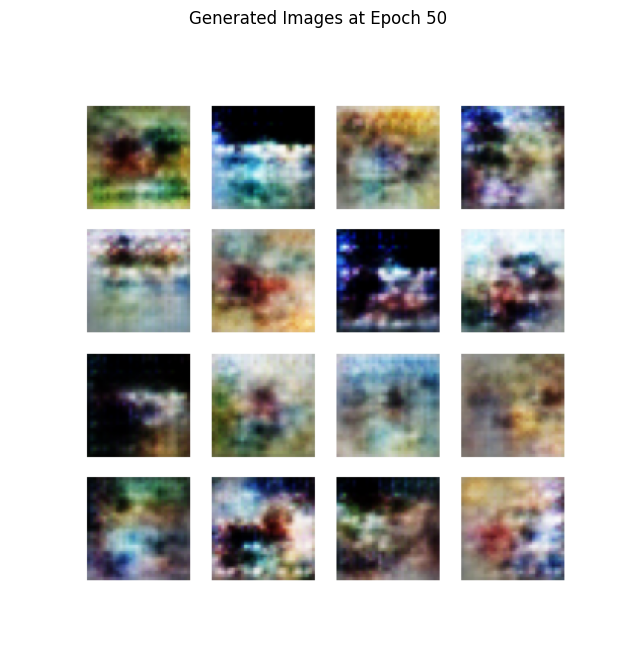

In [18]:
# Path to the saved image at epoch 50
image_path = 'generated_images_epoch_50.png'

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title('Generated Images at Epoch 50')
plt.show()

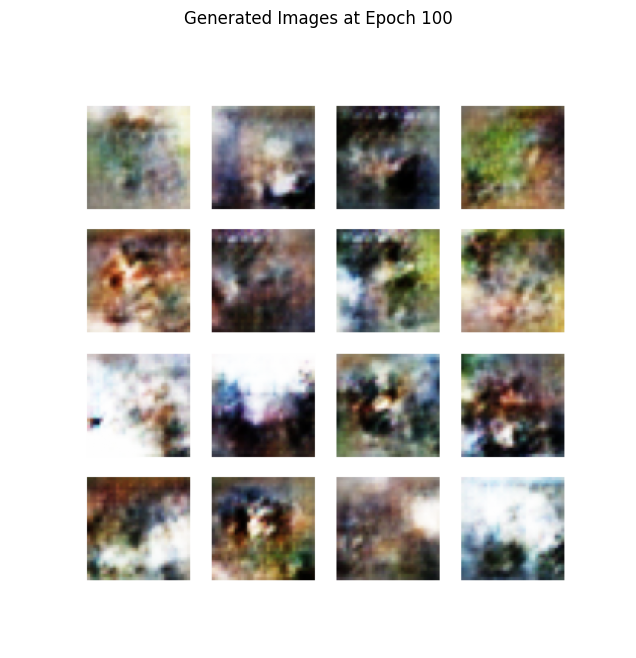

In [19]:
# Path to the saved image at epoch 100
image_path = 'generated_images_epoch_100.png'

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title('Generated Images at Epoch 100')
plt.show()

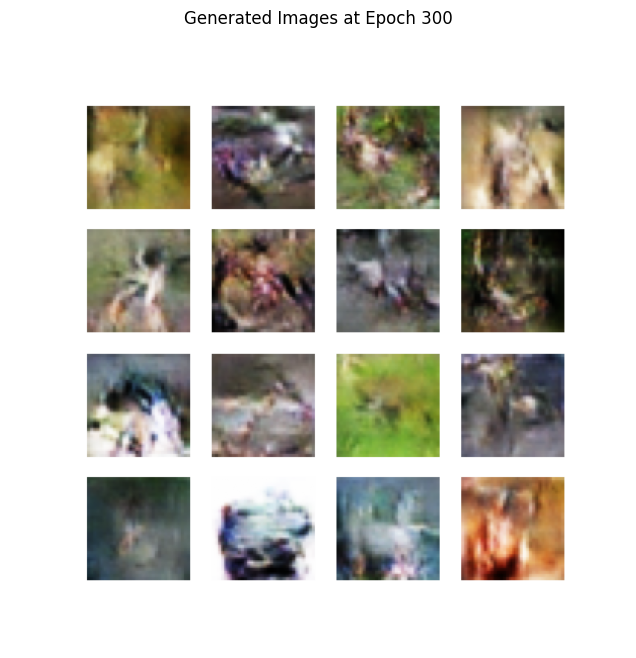

In [20]:
# Path to the saved image at epoch 300
image_path = 'generated_images_epoch_300.png'

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title('Generated Images at Epoch 300')
plt.show()